# Dataset Description

#### I crafted a custom dataset by meticulously gathering 2000 images from diverse sources, including Kaggle and various GitHub repositories, encompassing both resume and non-resume contexts.

# Importing Libraries

In [3]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
from torchvision import models
import warnings
warnings.filterwarnings('ignore')

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, MultiStepLR, CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils

# Data Preprocessing

In [4]:
# Constants
data_dir = '/kaggle/input/resume2classifier/Dataset_Resume'
batch_size = 32
learning_rate = 0.001
num_epochs = 10

In [5]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
# Load the dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Split the dataset into training and testing sets
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

In [7]:
# Create data loaders
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

# Model Architecture

The CNN model presented here is well-suited for resume classification due to its inherent architecture designed for image-related tasks. Leveraging convolutional layers with max-pooling, the model excels at automatically extracting intricate features from input images, a crucial capability for discerning patterns within resumes. The inclusion of Rectified Linear Unit (ReLU) activation functions introduces non-linearity, enabling the network to capture complex relationships in the data. The fully connected layer facilitates the final classification, outputting a binary result ideal for tasks like resume classification. The model's scalability to handle varying image sizes, simplicity in training, and the balance between complexity and performance make it an effective choice, particularly when dealing with a dataset of 2000 images. 

To further enhance the performance of the CNN model in resume classification, several strategic modifications and refinements can be considered. Firstly, implementing a more sophisticated attention mechanism within the model could augment its ability to focus on crucial regions in a resume, thereby improving feature extraction. 

In [8]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # First convolutional layer with 3 input channels, 16 output channels, 3x3 kernel, and padding
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        
        # Max pooling layer with 2x2 kernel and stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Second convolutional layer with 16 input channels, 32 output channels, 3x3 kernel, and padding
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layer with input size based on the assumed image size (32 * 56 * 56) and output size 2
        self.fc1 = nn.Linear(32 * 56 * 56, 2)  # Assuming input image size is 224x224

    def forward(self, x):
        # First convolutional layer followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # Second convolutional layer followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        
        # Reshape the tensor for the fully connected layer
        x = x.view(-1, 32 * 56 * 56)
        
        # Fully connected layer
        x = self.fc1(x)
        
        return x


In [9]:
# Initialize the model, loss function, and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train

In [11]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Lists to store metrics for each epoch
epochs_list = []
train_accuracy_list = []
precision_list = []
recall_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_correct = 0
    total_samples = 0
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = outputs.max(1)
        total_samples += labels.size(0)
        total_correct += predicted.eq(labels).sum().item()

        # Calculate true positive, true negative, false positive, false negative
        true_positive += ((predicted == 1) & (labels == 1)).sum().item()
        true_negative += ((predicted == 0) & (labels == 0)).sum().item()
        false_positive += ((predicted == 1) & (labels == 0)).sum().item()
        false_negative += ((predicted == 0) & (labels == 1)).sum().item()

    train_accuracy = total_correct / total_samples
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0

    # Append metrics to lists
    epochs_list.append(epoch + 1)
    train_accuracy_list.append(train_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)

    # Print training statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    
    # You can print other metrics as well, like confusion matrix
    cm = confusion_matrix(labels.numpy(), predicted.numpy())
    print(f'Confusion Matrix:\n{cm}')

Epoch [1/10], Train Accuracy: 0.6676, Precision: 0.6146, Recall: 0.9107
Confusion Matrix:
[[10  8]
 [ 2  8]]
Epoch [2/10], Train Accuracy: 0.7480, Precision: 0.7052, Recall: 0.8579
Confusion Matrix:
[[16  0]
 [12  0]]
Epoch [3/10], Train Accuracy: 0.8093, Precision: 0.7729, Recall: 0.8796
Confusion Matrix:
[[12  5]
 [ 2  9]]
Epoch [4/10], Train Accuracy: 0.8719, Precision: 0.8611, Recall: 0.8890
Confusion Matrix:
[[15  1]
 [ 1 11]]
Epoch [5/10], Train Accuracy: 0.8842, Precision: 0.8768, Recall: 0.8958
Confusion Matrix:
[[11  3]
 [ 2 12]]
Epoch [6/10], Train Accuracy: 0.9067, Precision: 0.9024, Recall: 0.9134
Confusion Matrix:
[[10  0]
 [ 5 13]]
Epoch [7/10], Train Accuracy: 0.9271, Precision: 0.9158, Recall: 0.9418
Confusion Matrix:
[[ 7  0]
 [ 1 20]]
Epoch [8/10], Train Accuracy: 0.9537, Precision: 0.9491, Recall: 0.9594
Confusion Matrix:
[[ 7  1]
 [ 0 20]]
Epoch [9/10], Train Accuracy: 0.9646, Precision: 0.9661, Recall: 0.9635
Confusion Matrix:
[[13  0]
 [ 1 14]]
Epoch [10/10], Trai

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


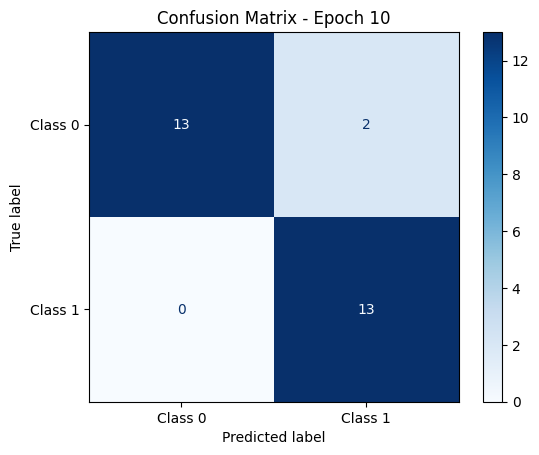

In [18]:
# Plot confusion matrix
cm = confusion_matrix(labels.numpy(), predicted.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
plt.show()

# Test

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set random seed for reproducibility
torch.manual_seed(42)

# Assuming you have a DataLoader named 'test_loader' and a model named 'model' already defined

model.eval()  # Set the model to evaluation mode
total_correct_test = 0
total_samples_test = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        _, test_predicted = test_outputs.max(1)
        total_samples_test += test_labels.size(0)
        total_correct_test += test_predicted.eq(test_labels).sum().item()
        all_predictions.extend(test_predicted.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

# Print confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print(f'Confusion Matrix:\n{cm}')


Test Accuracy: 0.8940
Precision: 0.8995, Recall: 0.8947, F1-Score: 0.8971
Confusion Matrix:
[[159  19]
 [ 20 170]]


# Confusion Matrix

The confusion matrix holds significant importance in the realm of machine learning, serving as a pivotal tool for the thorough evaluation of classification models. It goes beyond a simple accuracy score by providing a detailed breakdown of predictions into true positives, true negatives, false positives, and false negatives.

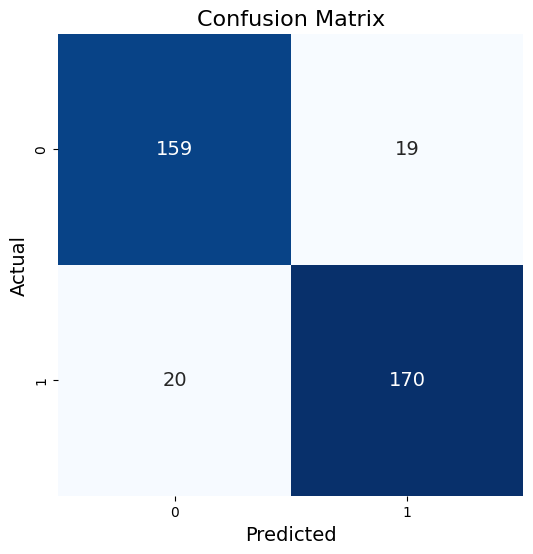

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       178
           1       0.90      0.89      0.90       190

    accuracy                           0.89       368
   macro avg       0.89      0.89      0.89       368
weighted avg       0.89      0.89      0.89       368



In [20]:
# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Display classification report
print(classification_report(all_labels, all_predictions))

# Plotting Results

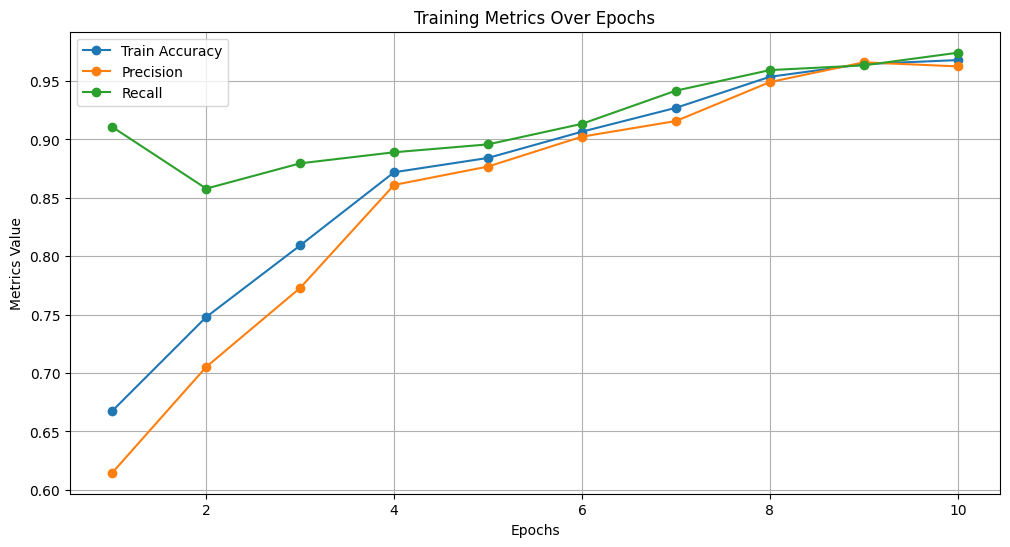

In [21]:
# Plotting
plt.figure(figsize=(12, 6))

plt.plot(epochs_list, train_accuracy_list, label='Train Accuracy', marker='o')
plt.plot(epochs_list, precision_list, label='Precision', marker='o')
plt.plot(epochs_list, recall_list, label='Recall', marker='o')

plt.title('Training Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics Value')
plt.legend()
plt.grid(True)
plt.show()